# Battle of the Neighborhoods: Where to Launch a New Italian Restaurant in Copenhagen
### Jessica Udsen

![Nyhavn](./nyhavn.jpg)

## Introduction: The Business Problem <a class="anchor" id="first-bullet"></a>

Copenhagen is an incredibly diverse city, with neighborhoods that are incredibly varied in terms of residents' ethnic backgrounds, income levels, and tastes. It is undeniable to any who live in the area that a neighborhood like Nørrebro has a distinctly different 'flavor' from Christianshavn. Therefore, it is reasonable to assume that certain types of restaurants do better in certain types of areas of the city. There are many location-based factors that could affect the success of a restaurant, for example, the saturation level of that sort of restaurant in the area, the quality of the nearby competition, and foot traffic around the location. 

Keeping these assumptions in mind, we will explore areas of Copenhangen by postal code and learn about the number of restaurants nearby and how many of those restaurants are Italian restaurants. Our aim is to locate postal codes where the number of restaurants is fairly low, the number of Italian restaurants is fairly low, and yet there is some sort of foot traffic nearby. 

## The Data <a class="anchor" id="second-bullet"></a>

In order to get the coordinates for each neighborhood in Copenhagen, we will use <a href="https://www.postnumre.dk/"> this list of Danish postal codes</a>, in combination with <a href="https://geocoder.readthedocs.io/">Python's Geocoder library</a>. After we locate each neighborhood by latitude and longitude, we will enter this data into the <a href="https://foursquare.com/city-guide">Foursquare City Guide API</a> and search for restaurants in each area (both Italian and non-Italian). We will store location data about the neighborhoods, including how many restaurants and how many Italian restaurants are near each postal code, in a dataframe. We will maintain a second dataframe that will contain information about each restaurant found in our Foursquare searches, including whether it is an Italian restaurant or not. 

In [58]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [59]:
#Use Beautiful Soup to scrape the table of postal codes off of postnumre.dk
URL = 'https://www.postnumre.dk/'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find('table')

In [60]:
#Read the results into a pandas dataframe
df = pd.read_html(str(results))
df = pd.DataFrame(df[0])
#df.head(5)

In [61]:
#Begin to clean the dataframe by resetting the column header
df.columns = df.iloc[0]
#df.head(5)

In [62]:
df.drop(df.index[0], inplace = True)
df.head(5)

0 Postnr.       Bynavn                 Gade
1    1050  København K       Kongens Nytorv
2    1051  København K               Nyhavn
3    1052  København K  Herluf Trolles Gade
4    1053  København K    Cort Adelers Gade
5    1054  København K    Peder Skrams Gade

In [63]:
#Copy the Copenhagen regions into a new dataframe, and translate the column headers into English
df_cph = pd.DataFrame(columns = ['Postnr.', 'City Region', 'Street'])

for i in range(len(df.index)):
    if 'København' in df.iloc[i,1]:
        df_cph = df_cph.append({'Postnr.': df.iloc[i,0], 'City Region': df.iloc[i,1], 'Street': df.iloc[i,2]}, ignore_index=True)

In [64]:
df_cph.head()

Postnr.  City Region               Street
0    1050  København K       Kongens Nytorv
1    1051  København K               Nyhavn
2    1052  København K  Herluf Trolles Gade
3    1053  København K    Cort Adelers Gade
4    1054  København K    Peder Skrams Gade

In [65]:
#Check that only regions of Copenhagen are included in the new table
df_cph['City Region'].unique()

array(['København K', 'København V', 'København Ø', 'København N',
       'København S', 'København NV', 'København SV'], dtype=object)

In [66]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [67]:
#Use Geocoder to get the coordinates of the center of each post number region
import geocoder

postCodeList = list(df_cph['Postnr.'])
coords_dict = {}

for postalCode in postCodeList:
    g = geocoder.osm('{}, Denmark'.format(postalCode))
    coords_dict[postalCode] = g.latlng
        
#coords_dict

In [68]:
#Convert the post number/coordinates dictionary above into a dataframe
latlng_df = pd.DataFrame(list(coords_dict.items()), columns = ['Postnr.', 'Coordinates'])
latlng_df.head()

Postnr.                               Coordinates
0    1050  [55.680603207894734, 12.585675826315791]
1    1051   [55.67998516037737, 12.590608396226415]
2    1052   [55.67886513793103, 12.590148344827588]
3    1053   [55.67801354545455, 12.590736818181819]
4    1054   [55.67799873333332, 12.588838733333334]

In [69]:
#Split the coordinates column into a latitude and longitude column and drop the coordinates column
latitude = []
longitude = []

for coords_set in latlng_df.Coordinates:
    latitude.append(coords_set[0])
    longitude.append(coords_set[1])

latlng_df['Latitude'] = latitude
latlng_df['Longitude'] = longitude

latlng_df.head()

Postnr.                               Coordinates   Latitude  Longitude
0    1050  [55.680603207894734, 12.585675826315791]  55.680603  12.585676
1    1051   [55.67998516037737, 12.590608396226415]  55.679985  12.590608
2    1052   [55.67886513793103, 12.590148344827588]  55.678865  12.590148
3    1053   [55.67801354545455, 12.590736818181819]  55.678014  12.590737
4    1054   [55.67799873333332, 12.588838733333334]  55.677999  12.588839

In [70]:
latlng_df.drop(columns=['Coordinates'], inplace = True)
latlng_df.head()

Postnr.   Latitude  Longitude
0    1050  55.680603  12.585676
1    1051  55.679985  12.590608
2    1052  55.678865  12.590148
3    1053  55.678014  12.590737
4    1054  55.677999  12.588839

In [71]:
#Join the latest coordinates dataframe with the preexisting post number and neighborhood dataframe
neighborhood_df = pd.merge(df_cph, latlng_df, on = 'Postnr.')
neighborhood_df.head() 

Postnr.  City Region               Street   Latitude  Longitude
0    1050  København K       Kongens Nytorv  55.680603  12.585676
1    1051  København K               Nyhavn  55.679985  12.590608
2    1052  København K  Herluf Trolles Gade  55.678865  12.590148
3    1053  København K    Cort Adelers Gade  55.678014  12.590737
4    1054  København K    Peder Skrams Gade  55.677999  12.588839

We now have a dataframe containing postnumber, region, street, and latitude and longitude data for Copenhagen's regions. 

In [72]:
#Set up Foursquare credentials 
CLIENT_ID = '4Q4N1TBQSPDXTXEUHUYSVCIZ5TS2TE33MXBDFV1TDOI0UJ5E' 
CLIENT_SECRET = 'AMIKIHDTDKGKLEVYIMYQ4OFKOZ1PRELAFACYP4LEHM2LHGID'
VERSION = '20200904'
LIMIT = 500
RADIUS = 500

In [73]:
from pandas import json_normalize

In [74]:
#The following functions (food_near_location and is_restaurant) are based on functions in this notebook: 
#https://nbviewer.jupyter.org/urls/cocl.us/coursera_capstone_notebook

food_category = '4d4b7105d754a06374d81259'
italian_categories = ['4bf58dd8d48988d110941735','55a5a1ebe4b013909087cbb6','55a5a1ebe4b013909087cb7c',
                                 '55a5a1ebe4b013909087cba7','55a5a1ebe4b013909087cba1','55a5a1ebe4b013909087cba4',
                                 '55a5a1ebe4b013909087cb95','55a5a1ebe4b013909087cb89','55a5a1ebe4b013909087cb9b',
                                 '55a5a1ebe4b013909087cb98','55a5a1ebe4b013909087cbbf','55a5a1ebe4b013909087cb79',
                                 '55a5a1ebe4b013909087cbb0','55a5a1ebe4b013909087cbb3','55a5a1ebe4b013909087cb74',
                                 '55a5a1ebe4b013909087cbaa','55a5a1ebe4b013909087cb83','55a5a1ebe4b013909087cb8c',
                                 '55a5a1ebe4b013909087cb92','55a5a1ebe4b013909087cb8f','55a5a1ebe4b013909087cb86',
                                 '55a5a1ebe4b013909087cbb9','55a5a1ebe4b013909087cb7f','55a5a1ebe4b013909087cbbc',
                                 '55a5a1ebe4b013909087cb9e','55a5a1ebe4b013909087cbc2','55a5a1ebe4b013909087cbad']

In [75]:
#Locate venues that sell food within a radius of 500 meters of a given latitude and longitude
def food_near_location(lat, lon):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, food_category, RADIUS, LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    dataframe = json_normalize(venues)
        
    if len(venues) == 0:
        return dataframe
        
    return dataframe[['venue.name','venue.id', 'venue.location.lat', 'venue.location.lng', 'venue.categories']]

In [76]:
#Distinguish between venues like cafeterias, sausage carts, and other informal venues and sit-down restaurants 
#(the only kind we're interested in, as they're more likely to be competition). This method returns two booleans, one
#indicating whether the venue is a restaurant, and one indicating whether it's an Italian restaurant.
def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse', 'tavern', 'kro']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c['name'].lower()
        category_id = c['id']
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if 'fast food' in category_name:
            restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

In [77]:
#Use the above 2 methods to create a dataframe of restaurants nearby each neighborhood's latitude and longitude, and keep track of how many restaurants 
#(Italian or otherwise) are in a region.
restaurant_df = pd.DataFrame(columns = ['Venue', 'Id', 'Latitude', 'Longitude', 'Italian?']) 

nearby_restaurants = []
nearby_italian = []

for i in neighborhood_df.index:
    nearby_food_df = food_near_location(neighborhood_df.loc[i, 'Latitude'], neighborhood_df.loc[i, 'Longitude'])
    nearby_restaurants_tot = 0
    nearby_italian_tot = 0
    
    if len(nearby_food_df.index) != 0:
        for j in nearby_food_df.index:
            restaurant, italian = is_restaurant(nearby_food_df.loc[j,'venue.categories'], italian_categories)
            if restaurant and italian:    
                restaurant_df = restaurant_df.append({'Venue': nearby_food_df.loc[j, 'venue.name'], 'Id': nearby_food_df.loc[j, 'venue.id'], 'Latitude': nearby_food_df.loc[j, 'venue.location.lat'], 'Longitude': nearby_food_df.loc[j, 'venue.location.lng'], 'Italian?' : 1}, ignore_index=True)
                nearby_restaurants_tot += 1
                nearby_italian_tot += 1
            if restaurant and not italian:
                restaurant_df = restaurant_df.append({'Venue': nearby_food_df.loc[j, 'venue.name'], 'Id': nearby_food_df.loc[j, 'venue.id'], 'Latitude': nearby_food_df.loc[j, 'venue.location.lat'], 'Longitude': nearby_food_df.loc[j, 'venue.location.lng'], 'Italian?' : 0}, ignore_index=True)
                nearby_restaurants_tot += 1
    
    nearby_restaurants.append(nearby_restaurants_tot)
    nearby_italian.append(nearby_italian_tot)
    

We now have a data frame containing information about all restaurants nearby our neighborhoods. We define as 'nearby' restaurants that are within 500 m of the latitude and longitude of our postal code. 

In [78]:
neighborhood_df['# Restaurants Nearby'] = nearby_restaurants
neighborhood_df['# Italian Restaurants Nearby'] = nearby_italian
neighborhood_df.head()

Postnr.  City Region               Street   Latitude  Longitude  \
0    1050  København K       Kongens Nytorv  55.680603  12.585676   
1    1051  København K               Nyhavn  55.679985  12.590608   
2    1052  København K  Herluf Trolles Gade  55.678865  12.590148   
3    1053  København K    Cort Adelers Gade  55.678014  12.590737   
4    1054  København K    Peder Skrams Gade  55.677999  12.588839   

   # Restaurants Nearby  # Italian Restaurants Nearby  
0                    76                             8  
1                    74                             8  
2                    71                             6  
3                    52                             5  
4                    72                             7

In [79]:
restaurant_df.shape

(14040, 5)

In [80]:
#Remove duplicates- the areas around these postal codes will overlap.
restaurant_df.drop_duplicates(inplace = True, ignore_index = True)
restaurant_df.head()

Venue                        Id   Latitude  Longitude Italian?
0  Restaurant Llama  533ac717498ea70a9dd24c9d  55.679570  12.583811        0
1    Den Lille Fede  4ba51dfbf964a5207ddf38e3  55.682199  12.585476        0
2           Cantina  575afea0498eb087743154bb  55.682427  12.584141        1
3              Otto  563a369dcd10a2b05544e2db  55.682648  12.586334        0
4              MASH  4ae9be54f964a52002b621e3  55.681874  12.588485        0

In [81]:
restaurant_df.shape

(556, 5)

In [82]:
import pickle

#Save dataframes as files so we don't have to keep accessing the API
neighborhood_df.to_pickle('./neighborhoods.pkl')
restaurant_df.to_pickle('./restaurants.pkl')


In [83]:
import pickle

#Unpickle
nbh_infile = open('neighborhoods.pkl','rb')
nbh_pkl = pickle.load(nbh_infile)
nbh_infile.close()

rest_infile = open('restaurants.pkl','rb')
rest_pkl = pickle.load(rest_infile)
rest_infile.close()

Below, we visualize all the nearby restaurants in our restaurant data frame. Italian restaurants are red, restaurants that are not Italian are blue.

In [84]:
#Create a map of CPH, show restaurants (Italian in red, other in blue)
import folium
from geopy.geocoders import Nominatim
import numpy as np

address = 'Copenhagen, DK'

geolocator = Nominatim(user_agent="cph_explorer")
location = geolocator.geocode(address)
latitude_cph = location.latitude
longitude_cph = location.longitude
map_cph = folium.Map(location=[latitude_cph, longitude_cph], zoom_start=12)

#Add the markers for each restaurant
for i in rest_pkl.index:
    if rest_pkl.loc[i, 'Italian?'] == 1:
        color_rest_type = 'red'
    else:
        color_rest_type = 'blue'
    label = folium.Popup(rest_pkl.loc[i, 'Italian?'], parse_html=True)
    folium.CircleMarker(
        [rest_pkl.loc[i, 'Latitude'], rest_pkl.loc[i, 'Longitude']],
        radius=5,
        popup=label,
        color=color_rest_type,
        fill=True,
        fill_color=color_rest_type,
        fill_opacity=0.7,
        parse_html=False).add_to(map_cph)  
    
map_cph

## Methodology

Our aim is to locate postal codes where the number of restaurants is fairly low, the number of Italian restaurants is fairly low, and yet there is some sort of foot traffic nearby. We will first do some preliminary analysis of the density of Italian restaurants around Copenhagen by creating a heatmap. Thereafter, we will use K-Means clustering on our neighborhood dataframe, clustering by the number of nearby restaurants, the number of nearby Italian restaurants, and the location. We will look at the characteristics of the clusters to decide which cluster(s) are most appropriate for a new location, and we will compare that information with our heatmap before making a final decision.

## Analysis

### Creating the Heatmap

In [85]:
#Heatmap of Italian restaurants near each neighborhood
from folium import plugins
from folium.plugins import HeatMap

restaurant_latlons = [[rest_pkl.loc[i, 'Latitude'], rest_pkl.loc[i, 'Longitude']] for i in rest_pkl.index]

heatmap_cph = folium.Map(location=[latitude_cph, longitude_cph], zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(heatmap_cph) #cartodbpositron cartodbdark_matter

#Add Italian restaurants to map- heat displays density of ITALIAN restaurants in an area
for i in rest_pkl.index:
    if rest_pkl.loc[i, 'Italian?'] == 1:   
        HeatMap(restaurant_latlons).add_to(heatmap_cph)

#Add markers for some interesting locations in CPH- click to see location label

#Kongens Nytorv
KN_lat = nbh_pkl[nbh_pkl['Street'] == 'Kongens Nytorv'].iloc[0]['Latitude']
KN_long = nbh_pkl[nbh_pkl['Street'] == 'Kongens Nytorv'].iloc[0]['Longitude']
KN = [KN_lat, KN_long]
folium.Marker(KN, popup = 'Kongens Nytorv').add_to(heatmap_cph)

#Nyhavn
NH_lat = nbh_pkl[nbh_pkl['Street'] == 'Nyhavn'].iloc[0]['Latitude']
NH_long = nbh_pkl[nbh_pkl['Street'] == 'Nyhavn'].iloc[0]['Longitude']
NH = [NH_lat, NH_long]
folium.Marker(NH, popup = 'Nyhavn').add_to(heatmap_cph)

#Amalienborg Castle
address_amalienborg = 'Amalienborg, 1257 København K'
amalienborg_location = geolocator.geocode(address_amalienborg)
amalienborg_lat = amalienborg_location.latitude
amalienborg_long = amalienborg_location.longitude
amalienborg = [amalienborg_lat, amalienborg_long]
folium.Marker(amalienborg, popup = 'Amalienborg Castle').add_to(heatmap_cph)

#Rosenborg Castle
address_rosenborg = 'Øster Voldgade 4A, 1350 København K'
rosenborg_location = geolocator.geocode(address_rosenborg)
rosenborg_lat = rosenborg_location.latitude
rosenborg_long = rosenborg_location.longitude
rosenborg = [rosenborg_lat, rosenborg_long]
folium.Marker(rosenborg, popup = 'Rosenborg Castle').add_to(heatmap_cph)

#Copenhagen Central Station
address_cph_central = 'Banegårdspladsen 1, 1570 København V'
cph_central_location = geolocator.geocode(address_cph_central)
cph_central_lat = cph_central_location.latitude
cph_central_long = cph_central_location.longitude
cph_central = [cph_central_lat, cph_central_long]
folium.Marker(cph_central, popup = 'Copenhagen Central Station').add_to(heatmap_cph)

#Tivoli
address_tivoli = 'Vesterbrogade 3, 1630 København V'
tivoli_location = geolocator.geocode(address_tivoli)
tivoli_lat = tivoli_location.latitude
tivoli_long = tivoli_location.longitude
tivoli = [tivoli_lat, tivoli_long]
folium.Marker(tivoli, popup = 'Tivoli Gardens').add_to(heatmap_cph)

#The Round Tower
address_RT = 'Købmagergade 52A, 1150 København K'
RT_location = geolocator.geocode(address_RT)
RT_lat = RT_location.latitude
RT_long = RT_location.longitude
RT = [RT_lat, RT_long]
folium.Marker(RT, popup = 'The Round Tower').add_to(heatmap_cph)

#Freetown Christiania
address_CHR = 'Prinsessegade, 1422 København K'
CHR_location = geolocator.geocode(address_CHR)
CHR_lat = CHR_location.latitude
CHR_long = CHR_location.longitude
CHR = [CHR_lat, CHR_long]
folium.Marker(CHR, popup = 'Freetown Christiania').add_to(heatmap_cph)

heatmap_cph

### Clustering

Now, we'll create a feature set in preparation for K-means clustering.

In [86]:
nbh_pkl.head()

Postnr.  City Region               Street   Latitude  Longitude  \
0    1050  København K       Kongens Nytorv  55.680603  12.585676   
1    1051  København K               Nyhavn  55.679985  12.590608   
2    1052  København K  Herluf Trolles Gade  55.678865  12.590148   
3    1053  København K    Cort Adelers Gade  55.678014  12.590737   
4    1054  København K    Peder Skrams Gade  55.677999  12.588839   

   # Restaurants Nearby  # Italian Restaurants Nearby  
0                    76                             8  
1                    74                             8  
2                    71                             6  
3                    52                             5  
4                    72                             7

In [87]:
X = nbh_pkl.loc[:,['Latitude', 'Longitude','# Restaurants Nearby', '# Italian Restaurants Nearby']]
X.head()

Latitude  Longitude  # Restaurants Nearby  # Italian Restaurants Nearby
0  55.680603  12.585676                    76                             8
1  55.679985  12.590608                    74                             8
2  55.678865  12.590148                    71                             6
3  55.678014  12.590737                    52                             5
4  55.677999  12.588839                    72                             7

These features vary substantially, so scaling the feature set is crucial. 

In [88]:
#Scaling using MinMax Scaler
from sklearn import preprocessing 

scaler = preprocessing.MinMaxScaler() 
X_scale = scaler.fit_transform(X) 

Using the elbow method, we determine how many clusters we should use when defining our K-Means model. 

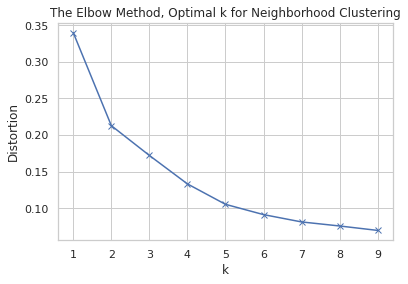

In [89]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

distortions = []

#Here, we choose optimal k for our model, in order to minimize distortion
for k in range(1,10):
    kmeans = KMeans(init = "k-means++", n_clusters = k, n_init = 12).fit(X_scale)
    distortions.append(sum(np.min(cdist(X_scale, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_scale.shape[0])

# Plot the elbow
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method, Optimal k for Neighborhood Clustering')
plt.show()

Below, we create and fit our K-Means model.

In [90]:
#K Means model
kmeans = KMeans(init = "k-means++", n_clusters = 2, n_init = 12).fit(X_scale)
nbh_pkl['Cluster'] = kmeans.labels_
nbh_pkl.head()

Postnr.  City Region               Street   Latitude  Longitude  \
0    1050  København K       Kongens Nytorv  55.680603  12.585676   
1    1051  København K               Nyhavn  55.679985  12.590608   
2    1052  København K  Herluf Trolles Gade  55.678865  12.590148   
3    1053  København K    Cort Adelers Gade  55.678014  12.590737   
4    1054  København K    Peder Skrams Gade  55.677999  12.588839   

   # Restaurants Nearby  # Italian Restaurants Nearby  Cluster  
0                    76                             8        0  
1                    74                             8        0  
2                    71                             6        0  
3                    52                             5        0  
4                    72                             7        0

Let's do some basic descriptive statistics on our clusters. 

#### Cluster 0 vs Cluster 1: Descriptive Statistics

In [91]:
#Filter the neighborhood data frame by cluster, to make 5 number summary calculation a little easier
cluster0_df = nbh_pkl[nbh_pkl['Cluster'] == 0]
cluster1_df = nbh_pkl[nbh_pkl['Cluster'] == 1]

In [92]:
#5 Number Summaries
from numpy import percentile

#This function takes in a column from nbh_pkl and provides a 5 number summary of that data for each cluster, using cluster0_df and cluster1_df
def FiveNumSumm(dataColumn):
    quart_0 = percentile(cluster0_df.loc[:,dataColumn],[25, 50, 75] )
    min_0, max_0 = cluster0_df.loc[:,dataColumn].min(), cluster0_df.loc[:,dataColumn].max()

    quart_1 = percentile(cluster1_df.loc[:,dataColumn],[25, 50, 75] )
    min_1, max_1 = cluster1_df.loc[:,dataColumn].min(), cluster1_df.loc[:,dataColumn].max()

    summ = pd.DataFrame(columns = ['Cluster', 'Min', '1st Quartile', 'Median', '3rd Quartile', 'Max'])
    summ = summ.append({'Cluster' : 0 , 'Min' : min_0, '1st Quartile' : quart_0[0], 'Median' : quart_0[1], '3rd Quartile' : quart_0[2], 'Max' : max_0} , ignore_index=True)
    summ = summ.append({'Cluster' : 1 , 'Min' : min_1, '1st Quartile' : quart_1[0], 'Median' : quart_1[1], '3rd Quartile' : quart_1[2], 'Max' : max_1} , ignore_index=True)

    return summ

In [93]:
numRest_summ = FiveNumSumm('# Restaurants Nearby')
numRest_summ

Cluster   Min  1st Quartile  Median  3rd Quartile   Max
0      0.0  32.0         47.75    57.0         65.25  77.0
1      1.0   0.0          5.00    15.0         24.00  42.0

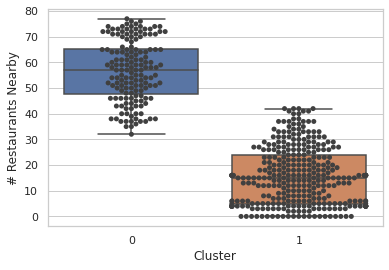

In [94]:
#Boxplots
import seaborn as sns

sns.set(style="whitegrid")
ax_restaurant_count = sns.boxplot(x = 'Cluster', y = '# Restaurants Nearby', data = nbh_pkl)
ax_restaurant_count = sns.swarmplot(x = 'Cluster', y= '# Restaurants Nearby', data = nbh_pkl, color=".25")

The neighborhoods in cluster 0 have a median number of restaurants nearby of 57. The distribution of restaurants nearby for cluster 0 looks nearly uniform. Meanwhile, the neighborhoods in cluster 1 have a median number of restaurants nearby of 15, and the data is skewed, with many neighborhoods in this cluster having lower numbers of restaurants nearby. The maximum number of nearby restaurants in cluster 1 is very large compared to the median (42 vs 15). While cluster 1 has a larger spread in terms of number of nearby restaurants, neighborhoods in cluster 1 generally have fewer restaurants than neighborhoods in cluster 0.

In [95]:
numItal_summ = FiveNumSumm('# Italian Restaurants Nearby')
numItal_summ

Cluster  Min  1st Quartile  Median  3rd Quartile   Max
0      0.0  2.0           4.0     5.0           7.0  11.0
1      1.0  0.0           1.0     1.0           3.0   5.0

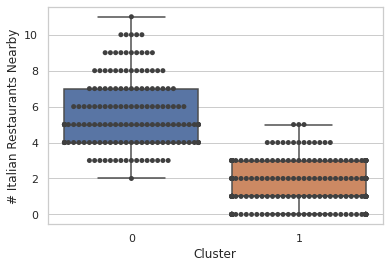

In [96]:
ax_ital_count = sns.boxplot(x = 'Cluster', y = '# Italian Restaurants Nearby', data = nbh_pkl)
ax_ital_count = sns.swarmplot(x = 'Cluster', y= '# Italian Restaurants Nearby', data = nbh_pkl, color=".25")

This boxplot immediately above indicates that the neighborhoods in cluster 0 have a median of 5 Italian restaurants nearby, whereas the neighborhoods in cluster 1 have a median of 1 Italian restaurant nearby. The vast majority of restaurants in cluster 1 have 1-3 Italian restaurants nearby, whereas there is more variability in the number of Italian restaurants in neighborhoods in cluster 0. That being said, it seems that most restaurants in cluster 0 have more than 5 Italian restaurants nearby, and 5 is the max number of Italian restaurants in neighborhoods in cluster 1. So, in most cases, restaurants in cluster 0 have more Italian restaurants nearby than restaurants in cluster 1.

Let's visualize where these clusters are in Copenhagen.

In [97]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude_cph, longitude_cph], zoom_start=12)

#Set the color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.Set1(np.linspace(0, 1, 7))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map- each cluster has its own color
markers_colors = []
for lat, lon, poi, cluster in zip(nbh_pkl['Latitude'], nbh_pkl['Longitude'], nbh_pkl['Postnr.'], nbh_pkl['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

#Add markers for some interesting locations in CPH- click to see location label

#Kongens Nytorv
KN_lat = nbh_pkl[nbh_pkl['Street'] == 'Kongens Nytorv'].iloc[0]['Latitude']
KN_long = nbh_pkl[nbh_pkl['Street'] == 'Kongens Nytorv'].iloc[0]['Longitude']
KN = [KN_lat, KN_long]
folium.Marker(KN, popup = 'Kongens Nytorv').add_to(map_clusters)

#Nyhavn
NH_lat = nbh_pkl[nbh_pkl['Street'] == 'Nyhavn'].iloc[0]['Latitude']
NH_long = nbh_pkl[nbh_pkl['Street'] == 'Nyhavn'].iloc[0]['Longitude']
NH = [NH_lat, NH_long]
folium.Marker(NH, popup = 'Nyhavn').add_to(map_clusters)

#Amalienborg Castle
address_amalienborg = 'Amalienborg, 1257 København K'
amalienborg_location = geolocator.geocode(address_amalienborg)
amalienborg_lat = amalienborg_location.latitude
amalienborg_long = amalienborg_location.longitude
amalienborg = [amalienborg_lat, amalienborg_long]
folium.Marker(amalienborg, popup = 'Amalienborg Castle').add_to(map_clusters)

#Rosenborg Castle
address_rosenborg = 'Øster Voldgade 4A, 1350 København K'
rosenborg_location = geolocator.geocode(address_rosenborg)
rosenborg_lat = rosenborg_location.latitude
rosenborg_long = rosenborg_location.longitude
rosenborg = [rosenborg_lat, rosenborg_long]
folium.Marker(rosenborg, popup = 'Rosenborg Castle').add_to(map_clusters)

#Copenhagen Central Station
address_cph_central = 'Banegårdspladsen 1, 1570 København V'
cph_central_location = geolocator.geocode(address_cph_central)
cph_central_lat = cph_central_location.latitude
cph_central_long = cph_central_location.longitude
cph_central = [cph_central_lat, cph_central_long]
folium.Marker(cph_central, popup = 'Copenhagen Central Station').add_to(map_clusters)

#Tivoli
address_tivoli = 'Vesterbrogade 3, 1630 København V'
tivoli_location = geolocator.geocode(address_tivoli)
tivoli_lat = tivoli_location.latitude
tivoli_long = tivoli_location.longitude
tivoli = [tivoli_lat, tivoli_long]
folium.Marker(tivoli, popup = 'Tivoli Gardens').add_to(map_clusters)

#The Round Tower
address_RT = 'Købmagergade 52A, 1150 København K'
RT_location = geolocator.geocode(address_RT)
RT_lat = RT_location.latitude
RT_long = RT_location.longitude
RT = [RT_lat, RT_long]
folium.Marker(RT, popup = 'The Round Tower').add_to(map_clusters)

#Freetown Christiania
address_CHR = 'Prinsessegade, 1422 København K'
CHR_location = geolocator.geocode(address_CHR)
CHR_lat = CHR_location.latitude
CHR_long = CHR_location.longitude
CHR = [CHR_lat, CHR_long]
folium.Marker(CHR, popup = 'Freetown Christiania').add_to(heatmap_cph)

map_clusters

## Results and Discussion

It seems that neighborhoods in cluster 0 roughly correspond to the 'hot spots' in the heatmap above- areas where there are many Italian restaurants. These 'hot spots' are also nearby a selection of popular tourist spots. The boxplots from above support this theory- neighborhoods in cluster 0 have more restaurants and more Italian restaurants (on average) compared to neighborhoods in cluster 1. It makes good sense to place a new Italian restaurant in a cluster 1 neighborhood that isn't too far from the 'hot spots' in Copenhagen. There is one particular area that looks very interesting- a grouping of cluster 1 neighborhoods nearly surrounded by cluster 0 neighborhoods, close to Gammel Strand. Let's take a closer look around post number 1208, which is in the Gammel Strand area and is in cluster 1. This post number is close to the cluster 0 neighborhoods.

In [98]:
import geopy.distance

dist_1208 = []
coords_1208 = (nbh_pkl[nbh_pkl['Postnr.'] == '1208'].loc[93, 'Latitude'], nbh_pkl[nbh_pkl['Postnr.'] == '1208'].loc[93, 'Longitude'])

for i in nbh_pkl.index:
    coords_nbh = (nbh_pkl.loc[i, 'Latitude'], nbh_pkl.loc[i, 'Longitude'])
    dist_1208.append(geopy.distance.distance(coords_nbh, coords_1208).km)
    
nbh_pkl['Distance (km) to Postnmr. 1208'] = dist_1208

nbh_pkl.head()

Postnr.  City Region               Street   Latitude  Longitude  \
0    1050  København K       Kongens Nytorv  55.680603  12.585676   
1    1051  København K               Nyhavn  55.679985  12.590608   
2    1052  København K  Herluf Trolles Gade  55.678865  12.590148   
3    1053  København K    Cort Adelers Gade  55.678014  12.590737   
4    1054  København K    Peder Skrams Gade  55.677999  12.588839   

   # Restaurants Nearby  # Italian Restaurants Nearby  Cluster  \
0                    76                             8        0   
1                    74                             8        0   
2                    71                             6        0   
3                    52                             5        0   
4                    72                             7        0   

   Distance (km) to Postnmr. 1208  
0                        0.760759  
1                        1.016111  
2                        0.955740  
3                        0.977861  
4                        0.858970

In [99]:
cluster1_df = nbh_pkl[nbh_pkl['Cluster'] == 1]

In [100]:
cluster1_1208 = cluster1_df.sort_values(by='Distance (km) to Postnmr. 1208')
cluster1_1208.reset_index(drop = True, inplace = True)
cluster1_1208.head(10)

Postnr.  City Region           Street   Latitude  Longitude  \
0    1208  København K   Kompagnistræde  55.677118  12.575274   
1    1210  København K     Knabrostræde  55.677520  12.574985   
2    1211  København K  Brolæggerstræde  55.677595  12.574652   
3    1204  København K        Magstræde  55.676453  12.575468   
4    1205  København K        Snaregade  55.677107  12.576522   
5    1466  København K     Rådhusstræde  55.676783  12.574170   
6    1203  København K        Nybrogade  55.676447  12.576140   
7    1206  København K          Naboløs  55.677537  12.577072   
8    1450  København K           Nytorv  55.677516  12.573354   
9    1207  København K     Hyskenstræde  55.678084  12.576626   

   # Restaurants Nearby  # Italian Restaurants Nearby  Cluster  \
0                    29                             2        1   
1                    34                             2        1   
2                    35                             2        1   
3                    26                             1        1   
4                    27                             1        1   
5                    33                             2        1   
6                    23                             1        1   
7                    27                             1        1   
8                    41                             2        1   
9                    37                             2        1   

   Distance (km) to Postnmr. 1208  
0                        0.000000  
1                        0.048372  
2                        0.066009  
3                        0.075066  
4                        0.078524  
5                        0.078811  
6                        0.092445  
7                        0.122325  
8                        0.128707  
9                        0.137119

In [101]:
#Create the map
goodLocations = folium.Map(location=[latitude_cph, longitude_cph], zoom_start=14)

#Add the markers for neighborhoods within .5 km of postnr. 1208
for i in cluster1_1208.index:
    if cluster1_1208.loc[i, 'Distance (km) to Postnmr. 1208'] < .5:
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [cluster1_1208.loc[i,'Latitude'], cluster1_1208.loc[i, 'Longitude']],
            radius=5,
            popup= cluster1_1208.loc[i, 'Postnr.'],
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(goodLocations)  
    
goodLocations

In [102]:
#Filter goodLoc_df by distance, so that it only includes neighborhoods within .5 km of 1208
goodLoc_df = cluster1_1208[cluster1_1208['Distance (km) to Postnmr. 1208'] < .5]
goodLoc_df.head(10)

Postnr.  City Region           Street   Latitude  Longitude  \
0    1208  København K   Kompagnistræde  55.677118  12.575274   
1    1210  København K     Knabrostræde  55.677520  12.574985   
2    1211  København K  Brolæggerstræde  55.677595  12.574652   
3    1204  København K        Magstræde  55.676453  12.575468   
4    1205  København K        Snaregade  55.677107  12.576522   
5    1466  København K     Rådhusstræde  55.676783  12.574170   
6    1203  København K        Nybrogade  55.676447  12.576140   
7    1206  København K          Naboløs  55.677537  12.577072   
8    1450  København K           Nytorv  55.677516  12.573354   
9    1207  København K     Hyskenstræde  55.678084  12.576626   

   # Restaurants Nearby  # Italian Restaurants Nearby  Cluster  \
0                    29                             2        1   
1                    34                             2        1   
2                    35                             2        1   
3                    26                             1        1   
4                    27                             1        1   
5                    33                             2        1   
6                    23                             1        1   
7                    27                             1        1   
8                    41                             2        1   
9                    37                             2        1   

   Distance (km) to Postnmr. 1208  
0                        0.000000  
1                        0.048372  
2                        0.066009  
3                        0.075066  
4                        0.078524  
5                        0.078811  
6                        0.092445  
7                        0.122325  
8                        0.128707  
9                        0.137119

In [103]:
#Create a new heatmap, add markers for each neighborhood in the above dataframe

heatmap_cph_2 = folium.Map(location=[coords_1208[0], coords_1208[1]], zoom_start=16)
folium.TileLayer('cartodbpositron').add_to(heatmap_cph_2) #cartodbpositron cartodbdark_matter

#Add Italian restaurants to map- heat displays density of Italian restaurants in an area
for i in rest_pkl.index:
    if rest_pkl.loc[i, 'Italian?'] == 1:   
        HeatMap(restaurant_latlons).add_to(heatmap_cph_2)
        
#Add top 10 neighborhoods in goodLoc dataframe
for i in range(10):
    nbh_coords = [goodLoc_df.loc[i, 'Latitude'], goodLoc_df.loc[i, 'Longitude']]
    folium.Marker(nbh_coords, popup = goodLoc_df.loc[i, 'Postnr.']).add_to(heatmap_cph_2)

heatmap_cph_2

With this heat map, we can see that the top 10 neighborhoods in the above dataframe are in low Italian restaurant density areas. However, if you zoom out slightly, you notice that these neighborhoods are not too far from the high Italian restaurant density areas. We want to choose neighborhoods that are close to high Italian restaurant density areas, because those areas are chosen for their proximity to busy city centers. However, we don't want those neighborhoods themselves to have a high Italian restaurant density. The top 10 neighborhoods in our above data frame fit these requirements.

## Conclusions

In this analysis, we explored areas of Copenhangen by postal code and investigated how Italian restaurants are distributed in these areas. Our aim was to locate postal codes where the number of restaurants is fairly low, the number of Italian restaurants is fairly low, and yet there is some sort of foot traffic nearby. We achieved this by creating heatmaps of Italian restaurants overlaid over Copenhagen, and comparing those results to the geographical locations of clusters generated by a K-Means algorithm based on the number of restaurants (Italian and otherwise) nearby a postal code. These comparisons lead to the identification of a region of Copenhagen near Gammel Strand that has few Italian restaurants, yet is surrounded by areas with many restaurants (indicating that the area has decently high foot-traffic). We generated a data frame containing details on 10 neighborhoods in this area that would be good candidates for the location of a new Italian restaurant. 